# trojai库是在深度学习的后门攻防中用于快速生成投毒数据和后门模型的工具包。 

## trojai的数据处理模块

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mp
import numpy as np
from tqdm import tqdm
import torch
import torchvision

trojai中集成几个比较常用的后门触发器，这些后门触发器可以在trojai.datagen.image_triggers中获得

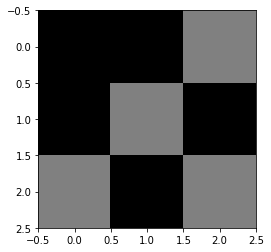

In [2]:
from trojai.datagen import image_triggers

# lamnda trigger
trigger = image_triggers.ReverseLambdaPattern(num_rows=3,num_cols=3,num_chan=3,trigger_cval=128)
plt.imshow(trigger.get_data())

旋转变换

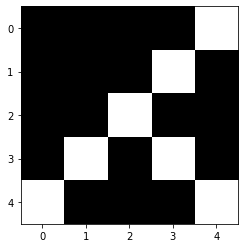

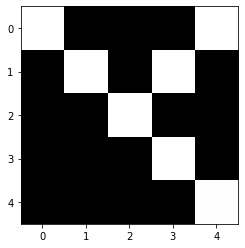

In [3]:
from trojai.datagen import image_affine_xforms
from trojai.datagen import image_triggers

trigger = image_triggers.ReverseLambdaPattern(5,5,3,255)
plt.imshow(trigger.get_data())
plt.show()

rotate_obj = image_affine_xforms.RotateXForm(90)
trigger = rotate_obj.do(trigger, None)
plt.imshow(trigger.get_data())
plt.show()

融合操作

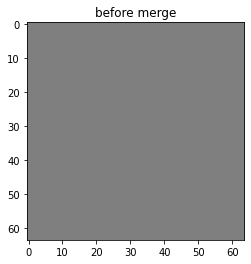

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


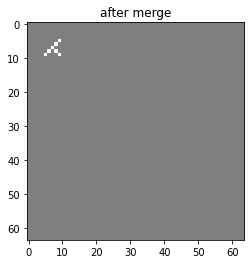

In [4]:
from trojai.datagen import insert_merges
from trojai.datagen import image_triggers
from trojai.datagen import image_entity

trigger = image_triggers.ReverseLambdaPattern(5,5,3,255)
merge_obj = insert_merges.InsertAtLocation(np.array([[5,5],[5,5],[5,5]]))
image = image_entity.GenericImageEntity(np.ones((64,64,3))*0.5)
plt.imshow(image.get_data())
plt.title('before merge')
plt.show()

merge_image = merge_obj.do(image, trigger, None)
plt.imshow(merge_image.get_data())
plt.title('after merge')
plt.show()


### 数据生成

首先自己生成一个清洁的数据和相应的文档，文档格式为csv，内容分为两列，分别为file和label，file是每一个清洁数据相对于文档的相对路径，label是每一个数据的正确标签。这里自定义一个最为简单的数据集，每个数据是一张纯色的图片，图片的灰度值在0-1之间（等价于1-255），如果灰度值小于0.5，则标签为0，否则标签为1.

In [152]:
def genWhiteAndBlackData(num, size, save_dir=None):
    import random
    image_list = []
    label_list = []
    for i in range(num):
        for label in range(2):
            flag = random.random()*0.5
            image = np.ones(size)*flag+label*0.5
            image_list.append(image)
            label_list.append(label)
            if save_dir:
                mp.imsave(save_dir + '/class_%s_example_%s.png'%(label, i), image)
    return image_list, label_list


def genDatasetForTrojai(image_list, label_list, datasetDesc, outf, datasetdir, description='generate dataset for trojai'):
    o = open(datasetdir + '/' + outf, 'w')
    o.write('file,label\n')
    for i in tqdm(range(len(label_list)), desc=description):
        filename = datasetdir + '/data/' + datasetDesc+'_'+str(i) + '.jpg'
        label = str(label_list[i])
        mp.imsave(filename, image_list[i])
        o.write('data/' + datasetDesc+'_'+str(i) + '.jpg')
        o.write(',')
        o.write(label)
        o.write('\n')
    o.close()


image_list, label_list = genWhiteAndBlackData(200,(64,64,3))
genDatasetForTrojai(image_list, label_list, 'white_and_black', 'white_and_black.csv', '/tmp/white_and_black')

generate dataset for trojai: 100%|██████████| 400/400 [00:00<00:00, 1966.76it/s]


In [153]:
from trojai.datagen import image_triggers
from trojai.datagen import image_affine_xforms
from trojai.datagen import config
from trojai.datagen import insert_merges
from trojai.datagen import xform_merge_pipeline
from trojai.datagen import datatype_xforms


my_config = config.XFormMergePipelineConfig(
    trigger_list=[image_triggers.ReverseLambdaPattern(3,3,3,255)],
    trigger_sampling_prob=None,
    trigger_xforms=[],
    trigger_bg_xforms=[],
    trigger_bg_merge=insert_merges.InsertAtLocation(np.asarray([[5,5],[5,5],[5,5]])),
    trigger_bg_merge_xforms=[datatype_xforms.ToTensorXForm()],
    merge_type='insert',
    per_class_trigger_frac=0.1
)

xform_merge_pipeline.modify_clean_image_dataset('/tmp/white_and_black', 'white_and_black.csv', '/tmp/white_and_black', 'mod1', my_config)

my_config.per_class_trigger_frac = None
xform_merge_pipeline.modify_clean_image_dataset('/tmp/white_and_black', 'white_and_black.csv', '/tmp/white_and_black', 'trigger_test', my_config)

Modifying Clean Dataset ...: 100%|██████████| 400/400 [00:00<00:00, 1150.63it/s]


生成实验

In [14]:
from trojai.datagen import experiment
from trojai.datagen import common_label_behaviors

behaviors = common_label_behaviors.WrappedAdd(1,2)
e = experiment.ClassicExperiment('/tmp/white_and_black', behaviors)
train_df = e.create_experiment('/tmp/white_and_black/white_and_black.csv','/tmp/white_and_black/mod1')
train_df.to_csv('/tmp/white_and_black/train.csv', index=False)

# 生成加入触发器的测试集
test_df = e.create_experiment('/tmp/white_and_black/white_and_black.csv','/tmp/white_and_black/trigger_test',trigger_frac=1.0)
test_df.to_csv('/tmp/white_and_black/test.csv',index=False)

# 生成未加触发器的测试集
test_clean_df = e.create_experiment('/tmp/white_and_black/white_and_black.csv','/tmp/white_and_black/clean_test',trigger_frac=0)
test_clean_df.to_csv('/tmp/white_and_black/test_clean.csv',index=False)

100%|██████████| 80/80 [00:00<00:00, 1087.44it/s]
/usr/local/anaconda3/envs/yz_torch/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
100%|██████████| 397/397 [00:00<00:00, 1074.00it/s]
/usr/local/anaconda3/envs/yz_torch/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
0it [00:00, ?it/s]


构建数据管理

In [2]:
from trojai.modelgen.data_manager import DataManager
from trojai.modelgen import architecture_factory
from trojai.modelgen.default_optimizer import DefaultOptimizer
from trojai.modelgen.config import TrainingConfig, DefaultOptimizerConfig, RunnerConfig
from trojai.modelgen.runner import Runner

In [15]:
def img_transform(x):
    return x.permute(2,0,1)/255.

manage_obj = DataManager(
    '/tmp/white_and_black', 
    'train.csv',
    'test_clean.csv',
    'test.csv',
    train_data_transform=img_transform,
    test_data_transform=img_transform
    )

构建随机化参数的空白模型

In [29]:
class MyArchefactory(architecture_factory.ArchitectureFactory):
    def new_architecture(self):
        import torchvision
        import torch
        model = torchvision.models.resnet18(pretrained=False)
        model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=2)
        return model

构建优化器并进行训练

In [30]:
train_config = TrainingConfig(
    device='cpu',
    epochs=30, 
    batch_size=16,
    lr=0.01,
)

optim_config = DefaultOptimizerConfig(train_config, None)
optim = DefaultOptimizer(optim_config)

runner_config = RunnerConfig(MyArchefactory(), manage_obj, optimizer=optim, model_save_dir='/tmp/white_and_black/models',filename='model.pt')
runner = Runner(runner_config)
runner.run()

Training will be VERY SLOW on a CPU with num_batches_per_metrics set to a value other than None.  If validation dataset metrics are still desired, consider increasing this value to speed up training
Argument 'persist_metadata' was not None nor type 'dict'. Argument will be ignored.
Training will be VERY SLOW on a CPU with num_batches_per_metrics set to a value other than None.  If validation dataset metrics are still desired, consider increasing this value to speed up training
Epoch 30/30: 100%|██████████| 23/23 [03:04<00:00,  8.01s/it, avg_train_loss=0.372] 


测试训练的模型效果

In [17]:
# 获取训练数据集。训练数据集是由清洁数据和投毒数据组成的，投毒数据站相应的比例
trainloader = torch.utils.data.DataLoader(next(manage_obj.load_data()[0]), batch_size=8)
# 获取清洁测试数据集，清洁测试数据集完全由清洁数据组成
testloader = torch.utils.data.DataLoader(manage_obj.load_data()[1], batch_size=8)
# 获取测试数据集，测试数据集完全由投毒数据组成
poisoned_loader = torch.utils.data.DataLoader(manage_obj.load_data()[2], batch_size=8)

In [18]:
import train_utils

model = torch.load('/tmp/white_and_black/models/model.pt.2')
print('dataloader acc')
train_utils.test_model(model, trainloader, torch.nn.CrossEntropyLoss(), device='cuda:0')
print('testloader acc')
train_utils.test_model(model, testloader, torch.nn.CrossEntropyLoss(), device='cuda:0')
print('triggeloader acc')
train_utils.test_model(model, poisoned_loader, torch.nn.CrossEntropyLoss(), device='cuda:0')

dataloader acc
|-------------|---------|---------|
| Iteration   |    loss |     acc |
|-------------|---------|---------|
| 0/50        | 0.05519 | 1.00000 |
| 16/50       | 0.08808 | 1.00000 |
| 32/50       | 0.40857 | 0.75000 |
| 48/50       | 0.19026 | 0.87500 |
|---------|---------|---------|
|    loss |     acc |    time |
|---------|---------|---------|
| 0.14367 | 0.96250 | 0.43974 |
testloader acc
|-------------|---------|---------|
| Iteration   |    loss |     acc |
|-------------|---------|---------|
| 0/50        | 0.06300 | 1.00000 |
| 16/50       | 0.09290 | 1.00000 |
| 32/50       | 0.02872 | 1.00000 |
| 48/50       | 0.09510 | 1.00000 |
|---------|---------|---------|
|    loss |     acc |    time |
|---------|---------|---------|
| 0.08006 | 0.99500 | 0.42056 |
triggeloader acc
|-------------|---------|---------|
| Iteration   |    loss |     acc |
|-------------|---------|---------|
| 0/50        | 0.34827 | 0.87500 |
| 16/50       | 0.50775 | 0.87500 |
| 32/50      